<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preamble" data-toc-modified-id="Preamble-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Preamble</a></span><ul class="toc-item"><li><span><a href="#General-parameters" data-toc-modified-id="General-parameters-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>General parameters</a></span></li></ul></li><li><span><a href="#Can-we-store-the-same-pattern-twice-in-a-sequence?" data-toc-modified-id="Can-we-store-the-same-pattern-twice-in-a-sequence?-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Can we store the same pattern twice in a sequence?</a></span><ul class="toc-item"><li><span><a href="#Really-close" data-toc-modified-id="Really-close-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Really close</a></span></li><li><span><a href="#Farther-away-loop" data-toc-modified-id="Farther-away-loop-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Farther away loop</a></span></li></ul></li></ul></div>

# Preamble

In [1]:
import  pprint
import  subprocess 
import sys 
sys.path.append('../')

import numpy as np
import scipy as sp
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

%matplotlib inline

np.set_printoptions(suppress=True, precision=5)

from network import Protocol, NetworkManager, Network
from patterns_representation import PatternsRepresentation
from analysis_functions import calculate_persistence_time, calculate_recall_quantities, calculate_triad_connectivity
from plotting_functions import plot_weight_matrix, plot_network_activity_angle, plot_persistent_matrix

## General parameters

In [2]:
epsilon = 10e-80
vmin = -3.0
remove = 0.010
dt = 0.001

sns.set(font_scale=3.5)
sns.set_style("whitegrid", {'axes.grid': False})
plt.rcParams['figure.figsize'] = (12, 8)
lw = 10
ms = 22
alpha_graph = 0.3
colors = sns.color_palette()

# Can we store the same pattern twice in a sequence?
* This involves first, immediate loops, and longer loops.
* It seems that if we make persistent time very big, the sequence does not advance. In this system, this happens because in the sequence 1 -> 2 -> 1-> 3   if 1 remains activated long enough again, two loses its adaptation charge and is available as an state again. This could be solved with a bit of asymmetry. 

## Really close

../connectivity_functions.py:15: RuntimeWarning: invalid value encountered in true_divide
  x = P / outer


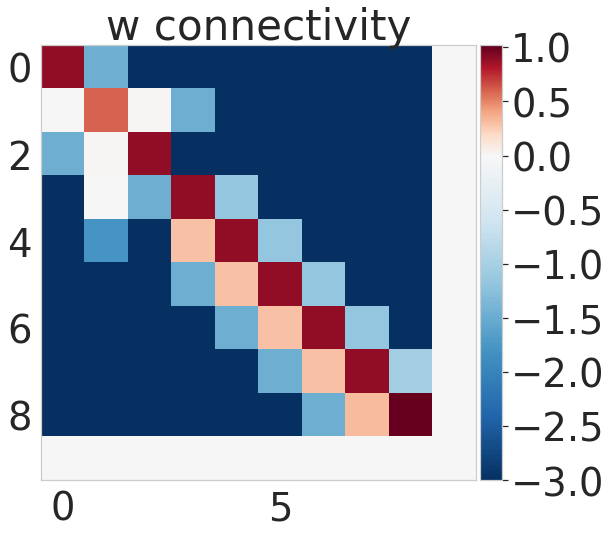

In [8]:
strict_maximum = True

g_a = 2.0
g_I = 10.0
tau_a = 0.250
G = 1.0
sigma_out = 0.0
tau_s = 0.010
tau_z_pre = 0.025
tau_z_post = 0.005

hypercolumns = 1
minicolumns = 10
n_patterns = 10

# Training protocol
training_times_base = 0.100
training_times = [training_times_base for i in range(n_patterns)]
ipi_base = 0.000
inter_pulse_intervals = [ipi_base for i in range(n_patterns)]
inter_sequence_interval = 0.0
resting_time = 0.0
epochs = 1
T_persistence = 0.200

# Manager properties
values_to_save = ['o']

# Neural Network
nn = Network(hypercolumns, minicolumns, G=G, tau_s=tau_s, tau_z_pre=tau_z_pre, tau_z_post=tau_z_post,
                 tau_a=tau_a, g_a=g_a, g_I=g_I, sigma_out=sigma_out, epsilon=epsilon, prng=np.random,
                 strict_maximum=strict_maximum, perfect=False, normalized_currents=True)


# Build the manager
manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)
# Build the representation
activity_representation = (np.array([0, 1, 2, 1, 3, 4, 5, 6, 7, 8])).reshape((10, 1))
representation = PatternsRepresentation(activity_representation,
                                        minicolumns=minicolumns)

# Build the protocol
protocol = Protocol()
protocol.simple_protocol(representation, training_times=training_times, inter_pulse_intervals=inter_pulse_intervals,
                    inter_sequence_interval=inter_sequence_interval, epochs=epochs, resting_time=resting_time)

# Run the protocol
timed_input = manager.run_network_protocol_offline(protocol=protocol)

manager.set_persistent_time_with_adaptation_gain(T_persistence=T_persistence, from_state=5, to_state=6)

plot_weight_matrix(manager, vmin=vmin)

success 0.0
[0, 1, 2, 1, 4, 5, 6, 7, 8]
[0.199, 0.398, 0.339, 0.356, 0.2, 0.2, 0.2, 0.2, 0.135]


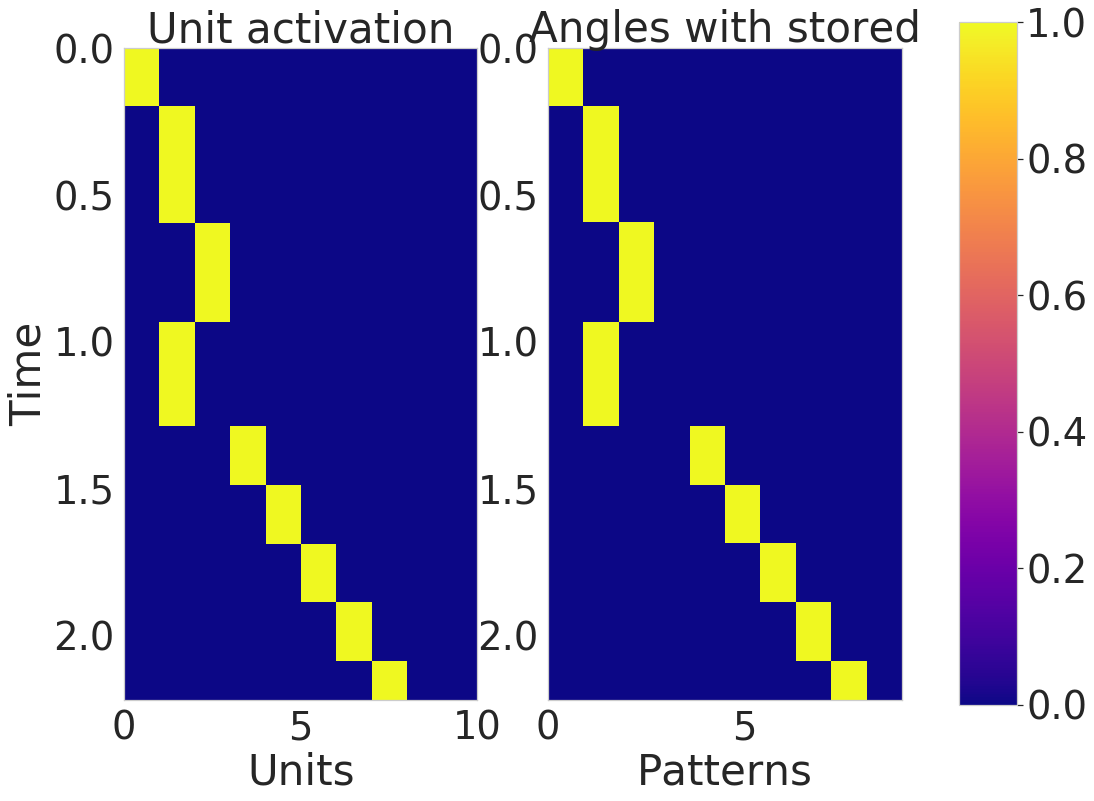

In [9]:
T_cue = tau_s
T_recall = T_persistence * (n_patterns + 1) + tau_s
nr = representation.network_representation
aux = calculate_recall_quantities(manager, nr, T_recall, T_cue, remove=remove, reset=True, empty_history=True)
success, pattern_sequence, persistent_times, timings = aux

plot_network_activity_angle(manager)
print('success', success)
print(pattern_sequence)
print(persistent_times)

../network.py:498: RuntimeWarning: invalid value encountered in log
  self.T = self.nn.tau_a * np.log(1 / (1 - self.B))
../network.py:502: RuntimeWarning: invalid value encountered in less
  self.T[self.T < 0] = 0.0


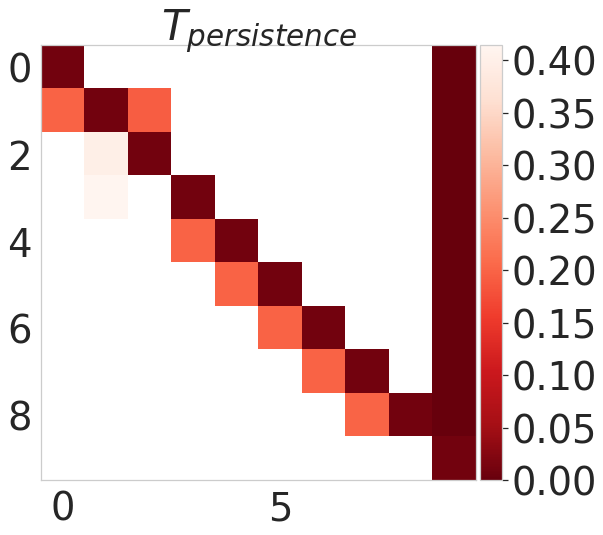

In [10]:
T_per = manager.calculate_persistence_time_matrix()
B = manager.B
plot_persistent_matrix(manager)

with T_persistence = 0.200 and symmetric tau_z constants (0.025 and 0.025) an scenario where T12 is smaller than everything else appears.

Why is T12 smaller (faster transition from 2 to 1 than from 1 to 2 or all the others for that matter)?
From the figure 1 -> 2 -> 1 -> 3 we can see that association (12) will appear twice in the sequence. First, it will appear when 12 (backwards) and then in 21 forward. 

This double association will imply that the weight w21 should be bigger. But it is not, they are actually the same (w21 = w12). Oddly enough the weight w11 is smaller than than w22, the effect as it can be appreciated in the calculation below arises due to the effects of the bias on the computation. 

In [6]:
w = manager.nn.w
beta = manager.nn.beta
print('T10', T_per[1, 0])
print('T21', T_per[2, 1])
print('T12', T_per[1, 2])
print('T31', T_per[1, 3])
print('T65', T_per[6, 5])
print('weights')
print('w10', w[1, 0])
print('w21', w[2, 1])
print('w12', w[1, 2])
print('w31', w[1, 3])
print('w65', w[6, 5])
print('self connections')
print('w11', w[1, 1])
print('w22', w[2, 2])
print('w33', w[3, 3])
print('w66', w[6, 6])
print('beta')
print('beta1', beta[1])
print('beta2', beta[2])
print('beta3', beta[3])
print('beta6', beta[6])
print('Bs')
print('B10', B[1, 0])
print('B21', B[2, 1])
print('B12', B[1, 2])
print('B31', B[1, 3])
print('B65', B[6, 5])

T10 0.49965210367568863
T21 nan
T12 0.46496681297003084
T31 nan
T65 0.4999999999999999
weights
w10 -0.0002930861320065148
w21 0.014235454834633288
w12 0.014235454833467998
w31 -1.46283250970698
w65 0.3005408581646354
self connections
w11 0.5969228268661797
w22 0.8970261454749391
w33 0.8970261456178263
w66 0.8970559142620933
beta
beta1 -0.6985354925620011
beta2 -0.9995654882259822
beta3 -0.9995654882259821
beta6 -0.9995654882259823
Bs
B10 0.8588294323679075
B21 1.2726807326402119
B12 0.8378194823034457
B31 2.9650108312237773
B65 0.8590257466285284


In [7]:
diff12 =  w[2, 2] - w[2, 1]
diff21 = w[1, 1] - w[1, 2]
print('diff12', diff12)
print('diff21', diff21)
print('bdiff', beta[1] - beta[2])
print('adding the bias reverses')
diff12 =  w[2, 2] - w[2, 1] + beta[2] - beta[1]
diff21 = w[1, 1] - w[1, 2] + beta[1] - beta[2]
print('diff12', diff12)
print('diff21', diff21)

diff12 0.8827906906403058
diff21 0.5826873720327117
bdiff 0.30102999566398114
adding the bias reverses
diff12 0.5817606949763247
diff21 0.8837173676966928


## Farther away loop

A little bit of noise seems to destroy it

../connectivity_functions.py:15: RuntimeWarning: invalid value encountered in true_divide
  x = P / outer


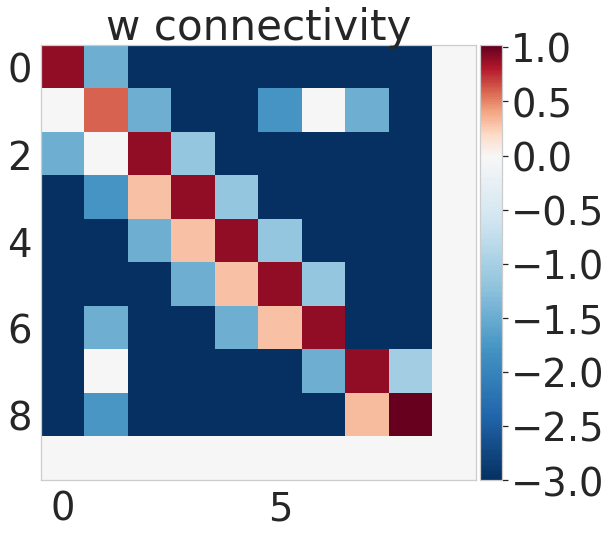

In [26]:
strict_maximum = True

g_a = 2.0
g_I = 10.0
tau_a = 0.250
G = 1.0
sigma_out = 0.0
tau_s = 0.010
tau_z_pre = 0.025
tau_z_post = 0.005

hypercolumns = 1
minicolumns = 10
n_patterns = 10

# Training protocol
training_times_base = 0.100
training_times = [training_times_base for i in range(n_patterns)]
ipi_base = 0.000
inter_pulse_intervals = [ipi_base for i in range(n_patterns)]
inter_sequence_interval = 0.0
resting_time = 0.0
epochs = 1
T_persistence = 0.050

# Manager properties
values_to_save = ['o']

# Neural Network
nn = Network(hypercolumns, minicolumns, G=G, tau_s=tau_s, tau_z_pre=tau_z_pre, tau_z_post=tau_z_post,
                 tau_a=tau_a, g_a=g_a, g_I=g_I, sigma_out=sigma_out, epsilon=epsilon, prng=np.random,
                 strict_maximum=strict_maximum, perfect=False, normalized_currents=True)


# Build the manager
manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)
# Build the representation
activity_representation = (np.array([0, 1, 2, 3, 4, 5, 6, 1, 7, 8])).reshape((10, 1))
representation = PatternsRepresentation(activity_representation,
                                        minicolumns=minicolumns)

# Build the protocol
protocol = Protocol()
protocol.simple_protocol(representation, training_times=training_times, inter_pulse_intervals=inter_pulse_intervals,
                    inter_sequence_interval=inter_sequence_interval, epochs=epochs, resting_time=resting_time)

# Run the protocol
timed_input = manager.run_network_protocol_offline(protocol=protocol)

manager.set_persistent_time_with_adaptation_gain(T_persistence=T_persistence, from_state=5, to_state=6)

plot_weight_matrix(manager, vmin=vmin)

success 1.0
[0, 1, 2, 3, 4, 5, 6, 1, 8, 9]
[0.055, 0.073, 0.051000000000000004, 0.051000000000000004, 0.051000000000000004, 0.051000000000000004, 0.077, 0.052000000000000005, 0.051000000000000004, 0.066]


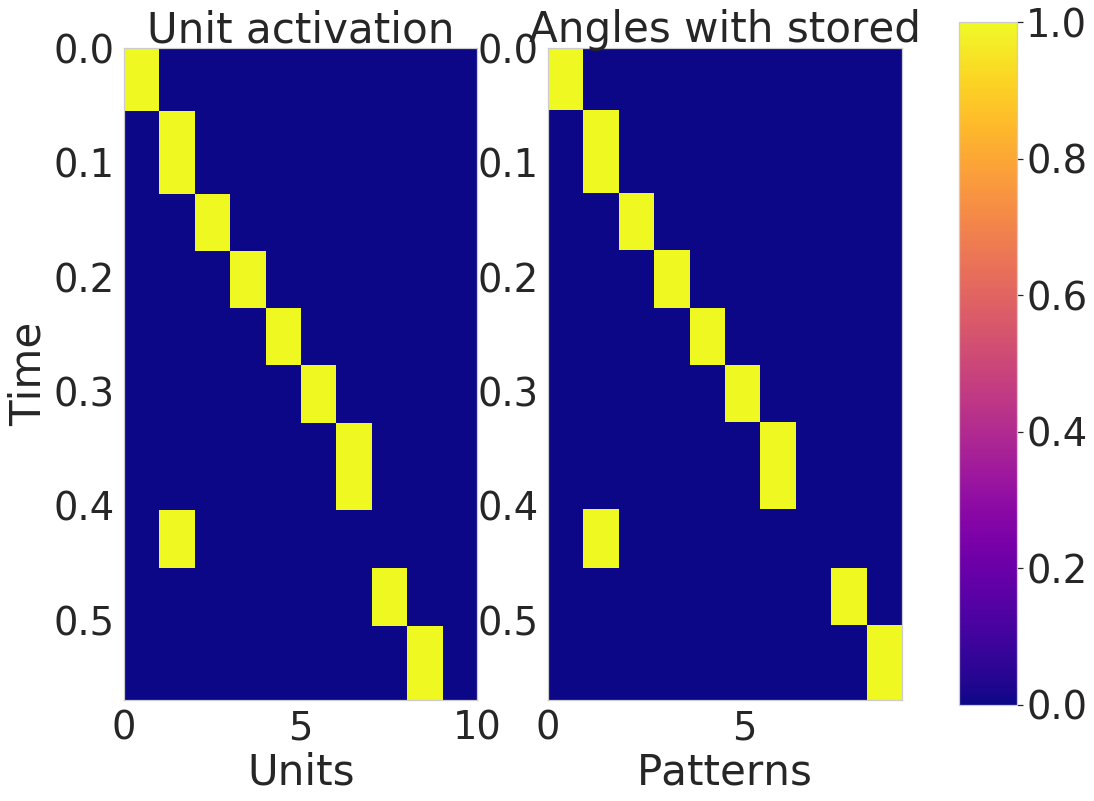

In [27]:
T_cue = tau_s
T_recall = T_persistence * (n_patterns + 1) + tau_s
nr = representation.network_representation
aux = calculate_recall_quantities(manager, nr, T_recall, T_cue, remove=remove, reset=True, empty_history=True)
success, pattern_sequence, persistent_times, timings = aux

plot_network_activity_angle(manager)
print('success', success)
print(pattern_sequence)
print(persistent_times)